In [32]:
# notebook to demo the project: loading data, feature engineering, data exploration and etc

In [33]:
# import
import utility as util
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta

In [34]:
# generate simulated data
df = util.generate_simulated_data()
df.head()

,patient_id,age,gender,bmi,blood_pressure,cholesterol_level,diabetes,heart_disease,last_visit_date
0,1,45,Male,22.5,120/80,Normal,No,No,2024-01-15
1,2,67,Female,31.2,145/95,High,Yes,Yes,2023-11-20
2,3,34,Male,27.5,118/76,Normal,No,No,2024-02-10
3,4,70,Female,35.6,160/100,High,Yes,Yes,2023-08-25
4,5,50,Male,29.8,130/85,Borderline,No,No,2023-12-30


In [35]:
df.describe()

,patient_id,age,bmi
count,10.00000,10.000000,10.000000
mean,5.50000,53.000000,28.910000
std,3.02765,16.485684,6.384434
min,1.00000,29.000000,18.700000
25%,3.25000,41.250000,24.925000
50%,5.50000,52.500000,28.650000
75%,7.75000,65.250000,32.550000
max,10.00000,80.000000,40.100000


📌 Risk Calculation Criteria:
Factor	Condition	Points
Age	> 60	+2
BMI	> 30 (Obese)	+2
Blood Pressure	Systolic > 140 OR Diastolic > 90	+2
Cholesterol Level	"High"	+2
Diabetes	"Yes"	+3
Heart Disease	"Yes"	+3
📌 Total Risk Score Range: 0 (low) - 12 (high)

In [36]:
# simple feature engineering
# last visit date
df["last_visit_date"] = pd.to_datetime(df["last_visit_date"])

# parse blood pressure
df[["systolic_bp", "diastolic_bp"]] = df["blood_pressure"].str.split("/",expand=True).astype(int)
df.drop(columns=["blood_pressure"], inplace=True)

# calculate risk factor
df["risk_score"] = df.apply(util.calculate_risk, axis=1)
# use risk score to classify risk level: 0-4 low, 5-8 medium, 9-12 high
df["risk_level"] = pd.cut(df["risk_score"], bins=[0, 4, 8, 12], labels=["Low", "Medium", "High"], include_lowest=True)

df.head()

,patient_id,age,gender,bmi,cholesterol_level,diabetes,heart_disease,last_visit_date,systolic_bp,diastolic_bp,risk_score,risk_level
0,1,45,Male,22.5,Normal,No,No,2024-01-15,120,80,0,Low
1,2,67,Female,31.2,High,Yes,Yes,2023-11-20,145,95,12,High
2,3,34,Male,27.5,Normal,No,No,2024-02-10,118,76,0,Low
3,4,70,Female,35.6,High,Yes,Yes,2023-08-25,160,100,12,High
4,5,50,Male,29.8,Borderline,No,No,2023-12-30,130,85,0,Low


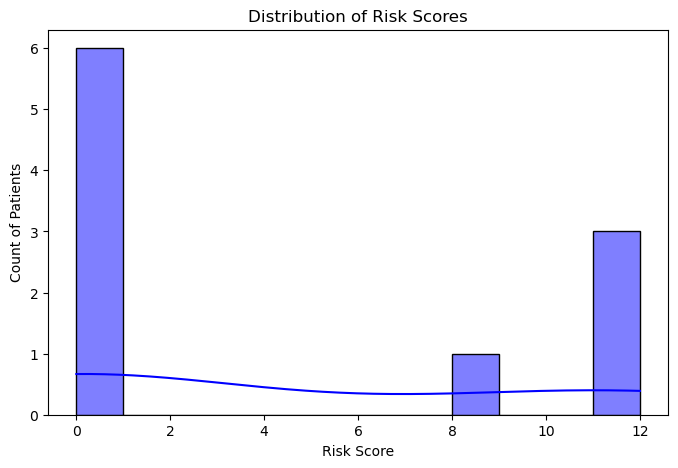

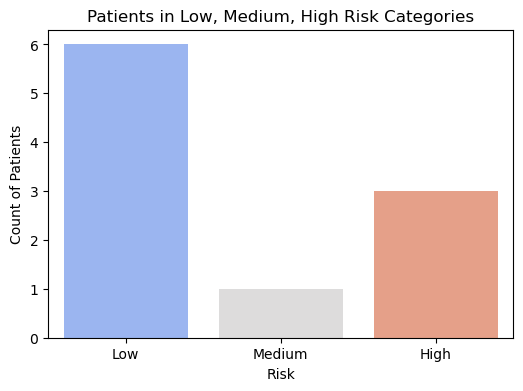

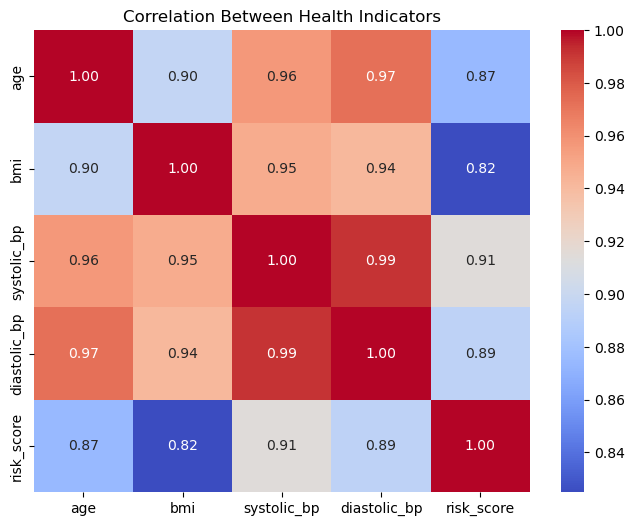

In [37]:
# visualize data 

plt.figure(figsize=(8,5))
sns.histplot(df["risk_score"], bins=12, kde=True, color="blue")
plt.xlabel("Risk Score")
plt.ylabel("Count of Patients")
plt.title("Distribution of Risk Scores")

# Risk levels
plt.figure(figsize=(6,4))
sns.countplot(x="risk_level", hue="risk_level", data=df, palette="coolwarm")
plt.xlabel("Risk")
plt.ylabel("Count of Patients")
plt.title("Patients in Low, Medium, High Risk Categories")
plt.show()

# correlation map
plt.figure(figsize=(8, 6))
sns.heatmap(df[["age", "bmi", "systolic_bp", "diastolic_bp", "risk_score"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Health Indicators")
plt.show()


In [38]:
# Use risk score threshold to identify patients who should be pioritized for follow-up
# if they visit the doctor longer than 6 months ago, they need to be reminded
# use today as the date to check status, can be replaced with any other date

time2use = datetime.today()
days_as_cutoff = 180
print(f'Time in use: {time2use}. Days as cutoff: {days_as_cutoff}')

cutoff_date = time2use - timedelta(days=180)

high_risk_patients = df[(df["risk_score"] >= 9) & (df["last_visit_date"] < cutoff_date)]

print(high_risk_patients)


Time in use: 2025-02-16 22:50:08.817232. Days as cutoff: 180
   patient_id  age  gender   bmi cholesterol_level diabetes heart_disease  \
1           2   67  Female  31.2              High      Yes           Yes   
3           4   70  Female  35.6              High      Yes           Yes   
6           7   80    Male  40.1              High      Yes           Yes   

  last_visit_date  systolic_bp  diastolic_bp  risk_score risk_level  
1      2023-11-20          145            95          12       High  
3      2023-08-25          160           100          12       High  
6      2023-05-18          170           110          12       High  


In [39]:
# advanced method
# code categorical data
# normalize numerical values
# use ML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

df_encoded = df.copy()

# encode Yes/No varaibles: diabetes, heart_disease
yes_no_category = ["diabetes", "heart_disease"]
for col in yes_no_category:
    df_encoded[col] = df_encoded[col].map({"No": 0, "Yes": 1})

# encode cholestrerol level
df_encoded["cholesterol_level"] = df_encoded["cholesterol_level"].map({"Normal": 0, "Borderline": 1, "High": 2})

# convert risk level into classification target
df_encoded["high_risk"] = df["risk_level"].map({"Low": 0, "Medium": 0, "High": 1})

# feature and target
features = ["age", "bmi", "systolic_bp", "diastolic_bp", "cholesterol_level", "diabetes", "heart_disease"]
X = df_encoded[features]
Y = df_encoded["high_risk"]



In [42]:
# normalize numerical features: age, bmi, bp
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split into training and testing 8-2
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=40, stratify=Y)

In [47]:
# Train classification models
# Logistic Regression, Random Forest, Support Vector Machine

# imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train logisitic regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)

# Train random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=40)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Train SVM
svm_model = SVC(kernel="linear", probability=True)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)


In [48]:
# Evaluate Models
print("📊 Logistic Regression Performance:")
print(classification_report(y_test, log_preds))

print("🌲 Random Forest Performance:")
print(classification_report(y_test, rf_preds))

print("💡 SVM Performance:")
print(classification_report(y_test, svm_preds))

📊 Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

🌲 Random Forest Performance:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

💡 SVM Performance:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33  

c:\ProgramData\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\Lib\site-pa